# 2024-INF1823 - Introduction à la science des données - Projet 2 
# Analyse de Données et Régression Linéaire avec PySpark


--- 

# Membre du groupe 
`DJIEUNANG NOUMBO NELIE Mabelle`

`GABRIEL-ATANGANA MBOA Bryan`

`TAMBAT Tresor Megane`


## Creation de la session spark

In [2]:
from pyspark.sql import SparkSession


spark = SparkSession.builder.getOrCreate()

24/11/20 17:45:34 WARN Utils: Your hostname, Bryans-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 132.213.168.5 instead (on interface en0)
24/11/20 17:45:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/20 17:45:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


--- 

## Chargement des données

In [29]:
# Chargement du dataset (création du dataframe)
data = "./data/Student_Performance.csv"

# chargement du dataset dans la dataframe
df = spark.read.csv(data, header=True, inferSchema=True)

# Stats générales de la dataframe
df.describe().show()

+-------+------------------+-----------------+--------------------------+-----------------+--------------------------------+------------------+
|summary|     Hours Studied|  Previous Scores|Extracurricular Activities|      Sleep Hours|Sample Question Papers Practiced| Performance Index|
+-------+------------------+-----------------+--------------------------+-----------------+--------------------------------+------------------+
|  count|             10000|            10000|                     10000|            10000|                           10000|             10000|
|   mean|            4.9929|          69.4457|                      NULL|           6.5306|                          4.5833|           55.2248|
| stddev|2.5893087961856183|17.34315225104711|                      NULL|1.695862976517708|              2.8673477777081446|19.212557799463337|
|    min|                 1|               40|                        No|                4|                               0|            

### Liste des features

*Hours Studied*: Le nombre total d'heures d'étude de chaque étudiant.

*Previous Scores*: Les notes obtenues par les étudiants lors des tests précédents.

*Extracurricular Activities*: L'étudiant participe ou non à des activités extrascolaires (Yes = oui ou No = non).

*Sleep Hours*:  Le nombre moyen d'heures de sommeil de l'étudiant par jour.

*Sample Question Papers Practiced*: Le nombre d'exemples d'examens auxquels l'étudiant s'est exercé.


### Variable cible

*Performance Index*:Une mesure de la performance globale de chaque élève. L'indice de performance représente les résultats scolaires de l'élève et a été arrondi à l'entier le plus proche. L'indice est compris entre 10 et 100, les valeurs les plus élevées indiquant une meilleure performance.

### Analyse des stats générales

En analysant le tableau des statistiques générales, nous pouvons tiré du dataset `Student_Performance` contient les données de 10 000 étudiants. La performance globale moyenne de cette population est d'environ 55 points. De plus, chaque étudiant à en moyenne de 6h30 de sommeil par jour. Nous pouvons aussi voir que ce dataset ne contient pas de valeurs manquantes

--- 

## Nettoyage des données

In [4]:
# Renommer les colonnes
# liste des nouveaux nom de colonne
new_col_names = [col.lower().replace(" ", "_") for col in df.columns]

# Applique les nouveaux noms de colonne sur la dataframe
df = df.toDF(*new_col_names)
df.describe().show()


+-------+------------------+-----------------+--------------------------+-----------------+--------------------------------+------------------+
|summary|     hours_studied|  previous_scores|extracurricular_activities|      sleep_hours|sample_question_papers_practiced| performance_index|
+-------+------------------+-----------------+--------------------------+-----------------+--------------------------------+------------------+
|  count|             10000|            10000|                     10000|            10000|                           10000|             10000|
|   mean|            4.9929|          69.4457|                      NULL|           6.5306|                          4.5833|           55.2248|
| stddev|2.5893087961856183|17.34315225104711|                      NULL|1.695862976517708|              2.8673477777081446|19.212557799463337|
|    min|                 1|               40|                        No|                4|                               0|            

### Labeled encoding
La colonne `extracurricular_activities` à 2 valeurs Yes et No, que nous pouvons encoder en 1 et 0 pour eviter des erreurs d'entrainement

In [5]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col

col_name = "extracurricular_activities"
output_col_name = f"{col_name}_encoded"

if output_col_name in df.columns:
    df = df.drop(output_col_name)

# Creer l'indexer
indexer = StringIndexer(
    inputCol=col_name,
    outputCol=output_col_name,
    handleInvalid="error"
)

# Applique la transformation
indexed_df = indexer.fit(df).transform(df)

indexed_df = indexed_df.drop(col_name)

# Caster la valeur attrinbuer aux label en int
indexed_df = indexed_df.withColumn(output_col_name, col(output_col_name).cast("int"))

indexed_df.describe().show()

# Inspecter pour voir les valeurs attribuer à Yes et  No.
indexer_model = indexer.fit(df)
print("Labels :", indexer_model.labels)


+-------+------------------+-----------------+-----------------+--------------------------------+------------------+----------------------------------+
|summary|     hours_studied|  previous_scores|      sleep_hours|sample_question_papers_practiced| performance_index|extracurricular_activities_encoded|
+-------+------------------+-----------------+-----------------+--------------------------------+------------------+----------------------------------+
|  count|             10000|            10000|            10000|                           10000|             10000|                             10000|
|   mean|            4.9929|          69.4457|           6.5306|                          4.5833|           55.2248|                            0.4948|
| stddev|2.5893087961856183|17.34315225104711|1.695862976517708|              2.8673477777081446|19.212557799463337|               0.49999795979181794|
|    min|                 1|               40|                4|                        

Nous avons réussi à effectuer un label encoding sur la variable catégorielle `extracurricular_activities` et à créer une nouvelle colonne appelée `extracurricular_activities_encoded`. La valeur 0 a été attribuée à No et la valeur 1 à Yes.

In [30]:
# Schéma de la nouvelle table
indexed_df.printSchema()

root
 |-- hours_studied: integer (nullable = true)
 |-- previous_scores: integer (nullable = true)
 |-- sleep_hours: integer (nullable = true)
 |-- sample_question_papers_practiced: integer (nullable = true)
 |-- performance_index: double (nullable = true)
 |-- extracurricular_activities_encoded: integer (nullable = true)



--- 

##  Analyse Exploratoire des Données



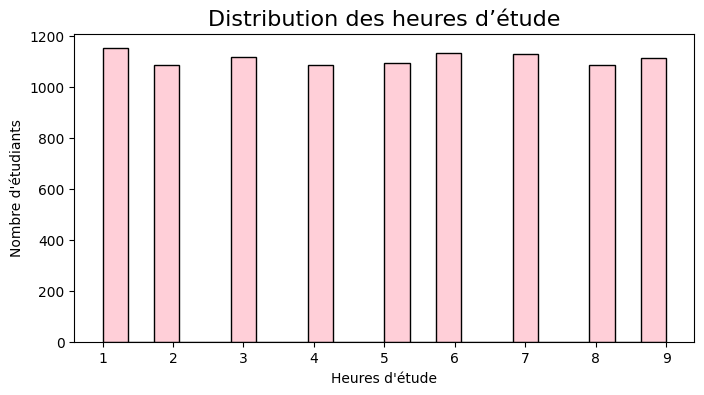

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Heure d'études
# Conversion du dataframe PySpark en Pandas
pandas_indexed_df = indexed_df.toPandas()

plt.figure(figsize=(8, 4))
sns.histplot(data=pandas_indexed_df, x='hours_studied', kde=False, color='pink')
plt.title('Distribution des heures d’étude', fontsize=16)
plt.xlabel("Heures d'étude")
plt.ylabel("Nombre d'étudiants")
plt.show()



Nous pouvons observer que, pour chaque tranche d'heures d'étude de 0 à 9, le nombre d'étudiants varie entre 1000 et 1200, ce qui indique un certain équilibre dans les données

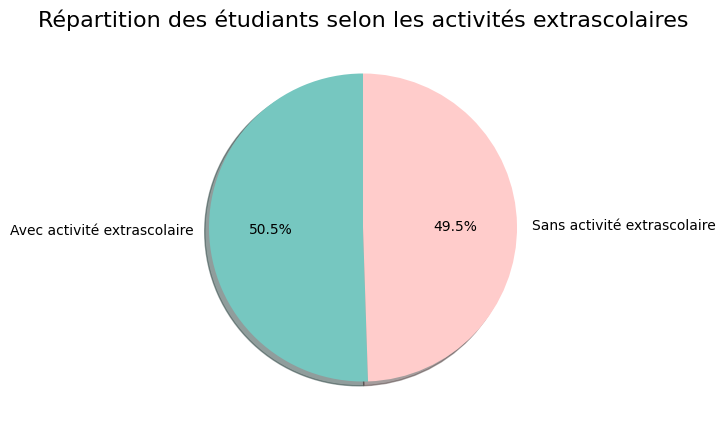

In [34]:
# Compte les valeurs
activity_counts = pandas_indexed_df['extracurricular_activities_encoded'].value_counts()

labels = ['Avec activité extrascolaire', 'Sans activité extrascolaire']

# Crée le pie chart
plt.figure(figsize=(5, 5))
plt.pie(
    activity_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#76c7c0', '#ffcccb'],
    explode=[0, 0],
    shadow=True
)

plt.title("Répartition des étudiants selon les activités extrascolaires", fontsize=16)
plt.show()



Du graphique ci-dessus, nous pouvons constater que le nombre d'étudiants ayant des activités extrascolaires est presque égal à celui de ceux qui n'en ont pas. Cela signifie que, d'après les données, la répartition des étudiants entre ceux qui participent à des activités extrascolaires et ceux qui n'y participent pas est relativement équilibrée.

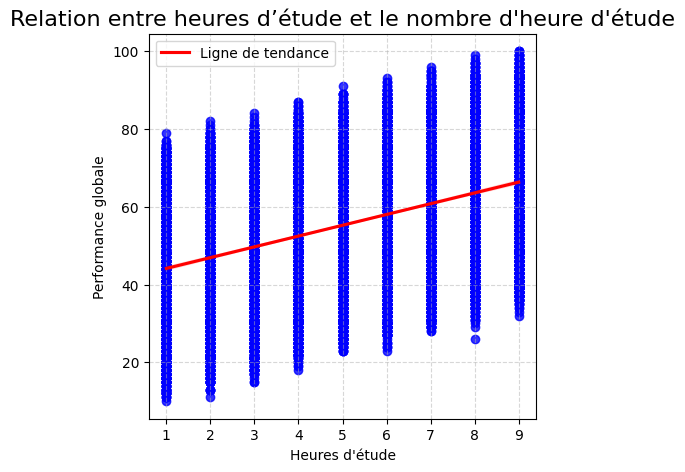

In [41]:
plt.figure(figsize=(5, 5))
sns.regplot(
    data=pandas_indexed_df,
    x='hours_studied',
    y='performance_index',
    color='blue',
    line_kws={ 'color': 'red',"label": "Ligne de tendance"}
)
plt.title("Relation entre heures d’étude et le nombre d'heure d'étude", fontsize=16)
plt.xlabel("Heures d'étude")
plt.ylabel("Performance globale")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Logiquement, on peut observer une tendance légèrement croissante entre la performance globale d'un étudiant et le nombre d'heures d'étude. Cependant, cette relation est assez faible. Nous ne pouvons donc pas conclure qu'un étudiant qui consacre plus d'heures à l'étude aura nécessairement une meilleure performance globale que celui qui en consacre moins. En effet, certains étudiants ayant étudié moins d'heures peuvent obtenir de meilleurs résultats que ceux ayant étudié davantage. Cette observation montre qu'il est difficile de tirer une conclusion définitive, car nous ne savons pas si tous les étudiants ont passé les mêmes épreuves, ni quelle méthode d'étude chaque étudiant a utilisée.

**Facteurs non pris en compte** : l'efficacité personnelle, ou encore les conditions de l'examen, peuvent jouer un rôle plus important que la quantité d'heures d'étude.

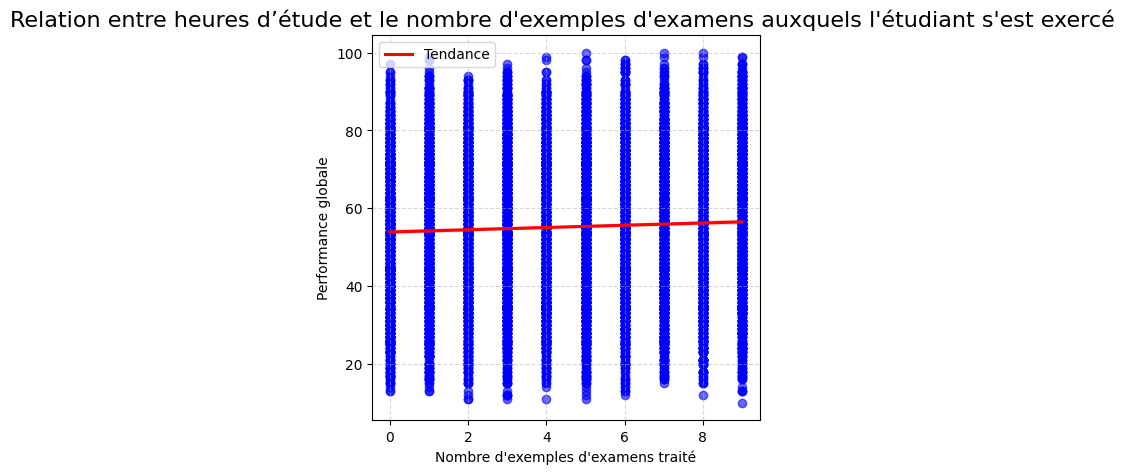

In [40]:
plt.figure(figsize=(5, 5))
sns.regplot(
    data=pandas_indexed_df,
    x='sample_question_papers_practiced',
    y='performance_index',
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red', 'label': 'Tendance'},
    color='blue'
)
plt.title("Relation entre heures d’étude et le nombre d'exemples d'examens auxquels l'étudiant s'est exercé ", fontsize=16)
plt.xlabel("Nombre d'exemples d'examens traité")
plt.ylabel("Performance globale")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


Nous pouvons dire que dans cette population, le nombre d'exemples d'examens traités par les étudiants semble influencer très peu voire pas du tout la performance globale des étudiants. Cela pourrait s'expliquer par le fait que les épreuves changent fréquemment, rendant les exemples d'examens traité moins pertinents pour prédire les résultats.

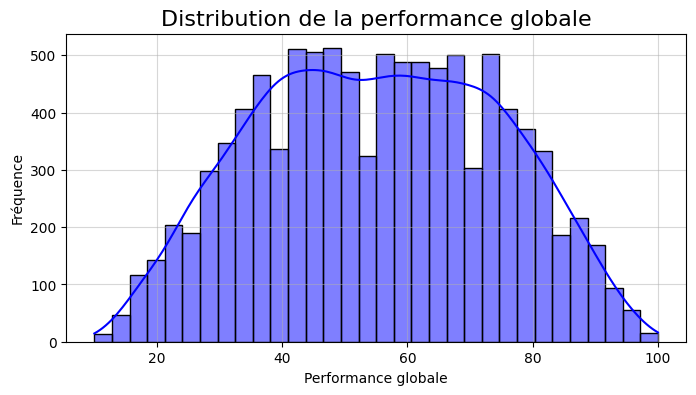

In [46]:
plt.figure(figsize=(8, 4))
sns.histplot(pandas_indexed_df['performance_index'], kde=True, color='blue' )
plt.title('Distribution de la performance globale', fontsize=16)
plt.xlabel('Performance globale')
plt.ylabel('Fréquence')
plt.grid(True, alpha=0.5)
plt.show()


La distribution semble être une courbe en forme de cloche, avec la fréquence la plus élevée autour du milieu de la fourchette des valeurs de la performance globale, et des fréquences plus faibles aux extrémités supérieures et inférieures de la performance. Cela suggère que la plupart des individus sont regroupés autour du niveau de performance moyen.

### Matrice de corrélation

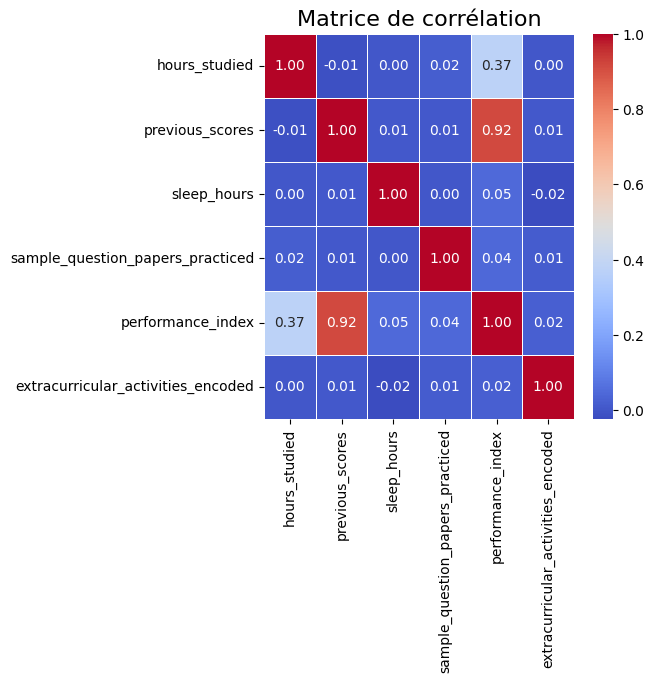

In [28]:
plt.figure(figsize=(5, 5))
correlation_matrix = pandas_indexed_df.corr()
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5
)
plt.title("Matrice de corrélation", fontsize=16)
plt.show()


Le graphique ci-dessus nous révèle que la variable previous_scores (les scores obtenues par un individus lors des tests précédents) est la plus pertinente à examiner, car elle présente une forte corrélation linéaire de **0.92** avec la performance globale, qui est notre variable cible. Vient ensuite le nombre d'heures d'étude de l'étudiant, qui montre une relation linéaire croissante mais beaucoup plus faible de **0.35** avec la performance globale.

## Regression linéaire

Nous allons donc utiliser la variable previous_scores, car selon la matrice de corrélation, elle est celle qui présente la relation linéaire la plus forte avec la performance globale (performance_index) qui la variable à prédire.

In [14]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

assembler = VectorAssembler(
    inputCols=["previous_scores"],
    outputCol="features4")

data = assembler.transform(indexed_df)
final_data = data.select("features4", "performance_index")

train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=16)


In [15]:
lr = LinearRegression(featuresCol="features4", labelCol="performance_index", predictionCol="predicted_performance_index")
lr_model = lr.fit(train_data)


24/11/20 17:46:21 WARN Instrumentation: [ab9c3cb0] regParam is zero, which might cause numerical instability and overfitting.
24/11/20 17:46:22 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/11/20 17:46:22 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [25]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = lr_model.transform(test_data)

# Racine de l'erreur quadratique moyenne
evaluator = RegressionEvaluator(labelCol="performance_index", predictionCol="predicted_performance_index", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("RMSE : {:.3f}".format(rmse))

# Calcul de R^2
evaluator_r2 = RegressionEvaluator(labelCol="performance_index", predictionCol="predicted_performance_index", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print("R2 : {:.3f}".format(r2))

# Erreur absolue moyenne (MAE)
evaluator_mae = RegressionEvaluator(labelCol="performance_index", predictionCol="predicted_performance_index", metricName="mae")
mae = evaluator_mae.evaluate(predictions)
print("MAE : {:.3f}".format(mae))

# Erreur quadratique moyenne (MSE)
evaluator_mse = RegressionEvaluator(labelCol="performance_index", predictionCol="predicted_performance_index", metricName="mse")
mse = evaluator_mse.evaluate(predictions)
print("MSE : {:.3f}".format(mse))



RMSE : 7.899
R2 : 0.833
MAE : 6.747
MSE : 62.394


## Explication des résultats

### 1. **Erreur Moyenne Quadratique (RMSE) : 7.899**

**RMSE** mesure la différence moyenne entre les valeurs prédites par le modèle et les valeurs réelles. Plus la valeur de l'erreur quadratique moyenne est petite, meilleur est le modèle.

- **Interprétation** :
  - Un **RMSE de 7.899** signifie qu'en moyenne, les prédictions du modèle s'écartent de la performance globale (`performance_index`) réelle d'environ **8** points.
  - Par exemple, si la performance globale réelle d'un étudiant est de **80**, la valeur de la performance prédite serait en moyenne dans la plage de **80 ± 7.899** (entre **72 - 88** approximativement).

---

### 2. **R-carré (R²) : 0.833**

**R²** indique à quel point le modèle explique la variance de la performance globale de l'étudiant. Il nous dit quelle proportion de la variance totale est expliquée par notre modèle.

- **Interprétation** :
  - Un **R² de 0.833** signifie que **83.3 %** de la variance de la preformance globale d'un étudiant peut être expliquée par les notes obtenues par cet individu lors des tests précédents (`previous_scores`). La valeur du R² (0.833) suggère que les scores obtenues par cet étudiant lors des tests précédents est un très bon prédicteur du de sa performance global.
  - Par example, si l'on prédit les scores d'examen avec les scores précédents, **83.3 %** de la variabilité des performances d'examen est expliquée par les scores précédents. Cela montre que les scores précédents d'un étudiant sont un déterminant majeur de la performance actuelle de cet étudiant.

---

### 3. **Erreur Absolue Moyenne (MAE) : 6.747**

**MAE** mesure la moyenne des erreurs absolues entre les valeurs prédites et réelles. Contrairement au RMSE, le MAE ne pénalise pas davantage les grandes erreurs, tandis que le RMSE donne plus de poids aux grandes erreurs.

- **Interprétation** :
  - Un **MAE de 6.747** signifie qu'en moyenne, les prédictions du modèle s'écartent d'environ **7** points de la performance globale réelle.
  - Par exemple, pour un indice de performance global réel de **80**, la valeur prédite serait en moyenne écartée de **±6.747** points, ce qui signifie que la valeur prédite pourrait varier entre **73.25 et 86.75**.

---

### 4. **Erreur Quadratique Moyenne (MSE) : 62.394**

**MSE** mesure la moyenne des différences au carré entre les valeurs prédites et réelles. Il pénalise davantage les grandes erreurs que le MAE en raison de l'élévation des résidus au carré, ce qui le rend sensible aux valeurs aberrantes.

- **Interprétation** :
  - **MSE = 62.394** signifie que l'erreur quadratique moyenne entre les valeurs prédites et réelles de la performance globale `performance_index` est de **62.394**.
  - Puisque le MSE est plus grand que le MAE, il reflète que les erreurs du modèle incluent certaines grandes erreurs.

---

### **Conclusion :**

Le modèle de régression linéaire fonctionne **bien** avec les scores précédents comme prédicteur de l'indice de performance, atteignant un R² de **0.833**. Cela signifie qu'environ **83%** de la variation de la performance globale d'un individu peut être expliquée par ses scores précédents, ce qui montre que ces derniers sont un bon prédicteur de la performance actuelle.

Les métriques d'erreur, comme l'**Erreur Quadratique Moyenne (RMSE)** de **7.899** et l'**Erreur Absolue Moyenne (MAE)** de **6.747**, indiquent que le modèle est relativement précis, avec des erreurs moyennes inférieures à 8 points. Cela suggère que les prédictions du modèle sont en moyenne proches de la réalité, bien qu'il reste encore quelques écarts à corriger.

Étant donné cette bonne performance, ce modèle pourrait être très utile pour prédire la performance des étudiants en fonction de leurs scores précédents. Cependant, pour améliorer encore la qualité des prédictions, il serait pertinent d'explorer l'ajout de nouvelles caractéristiques, telle que le nombre d'heures d'étude(`hours_studied`) qui pourraient enrichir le modèle et améliorer sa capacité à prédire l'indice de performance de manière plus précise.

### Sources utiles
MLlib (DataFrame-based) — PySpark 3.5.3 documentation. (n.d.). https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html 

loading. . . | SAP Help Portal. (n.d.). https://help.sap.com/docs/SAP_PREDICTIVE_ANALYTICS/41d1a6d4e7574e32b815f1cc87c00f42/5e5198fd4afe4ae5b48fefe0d3161810.html

API reference — seaborn 0.13.2 documentation. (n.d.). https://seaborn.pydata.org/api.html

https://www.machinelearningplus.com/pyspark/pyspark-linear-regression/ 


